In [ ]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 1.7 MB/s eta 0:00:00


In [ ]:
import duckdb

import mplsoccer
from mplsoccer import Pitch, VerticalPitch

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
df_stories = duckdb.sql(f"""
    SELECT * FROM '/content/drive/MyDrive/footly_data/stories.parquet'
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
df_stories['type'].value_counts()

,count
type,
pass,968435
duel,470156
touch,139383
interception,94640
game_interruption,75443
throw_in,42627
free_kick,27878
shot,26460
infraction,25460


In [ ]:
df = duckdb.sql(f"""
    SELECT * FROM '/content/drive/MyDrive/footly_data/stories.parquet'
    WHERE type = 'shot'
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
df.shape

(26460, 138)

In [ ]:
df['end_y'].value_counts()

,count
end_y,
-1,26460


In [ ]:
# Create a copy and scale the coordinates to real pitch dimensions (105x68 meters)
df_copy = df.copy()
df_copy["X"] = (100 - df["start_x"]) * (105 / 100)
df_copy["Y"] = (100 - df["start_y"]) * (68 / 100)
df_copy["C"] = ((df_copy["start_y"] - 50) * (68/100))

#calculate distance and angle
df_copy["Distance"] = np.sqrt(df_copy["X"]**2 + df_copy["C"]**2)
df_copy["Angle"] = np.where(np.arctan(7.32 * df_copy["X"] / (df_copy["X"]**2 + df_copy["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * df_copy["X"] /(df_copy["X"]**2 + df_copy["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * df_copy["X"] /(df_copy["X"]**2 + df_copy["C"]**2 - (7.32/2)**2)) + np.pi)

df_copy.head(3)

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__,X,Y,C,Distance,Angle
0,AMF,False,94,False,False,False,False,False,shot,False,...,True,1296149405,0,False,108,6.30,39.44,-5.44,8.323677,0.689889
1,RAMF,False,84,False,False,False,False,False,shot,False,...,False,1296149442,0,True,132,16.80,42.16,-8.16,18.676873,0.351405
2,RDMF,False,79,False,False,False,False,False,shot,False,...,False,1296149527,0,False,198,22.05,22.44,11.56,24.896508,0.260123


In [ ]:
df_copy.to_csv("/content/drive/MyDrive/footly_data/xG_df_copy", index=False)

In [ ]:
df['goal'].value_counts()

,count
goal,
False,23492
True,2968


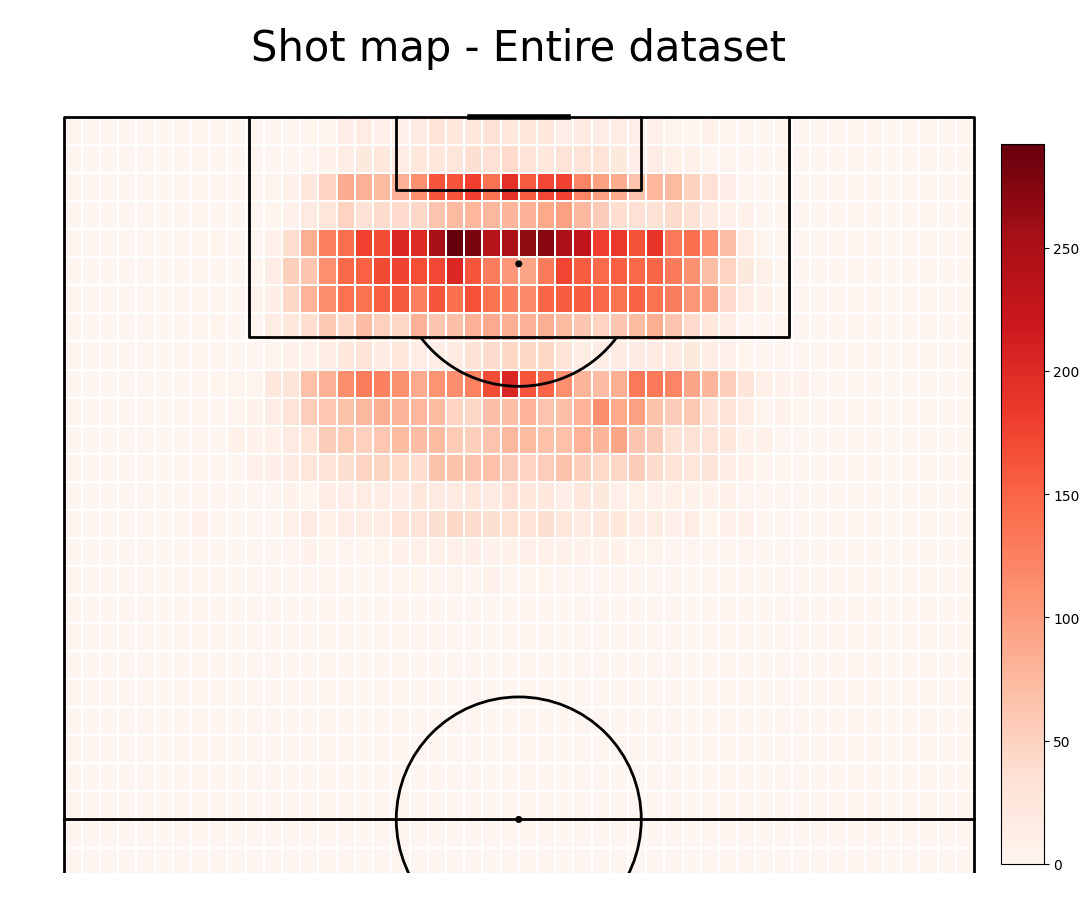

In [ ]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#subtracting x from 105 but not y from 68 because of inverted Wyscout axis
#calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - df_copy["X"], df_copy["Y"], bins=50)
#make heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot map - Entire dataset' , fontsize = 30)
plt.show()

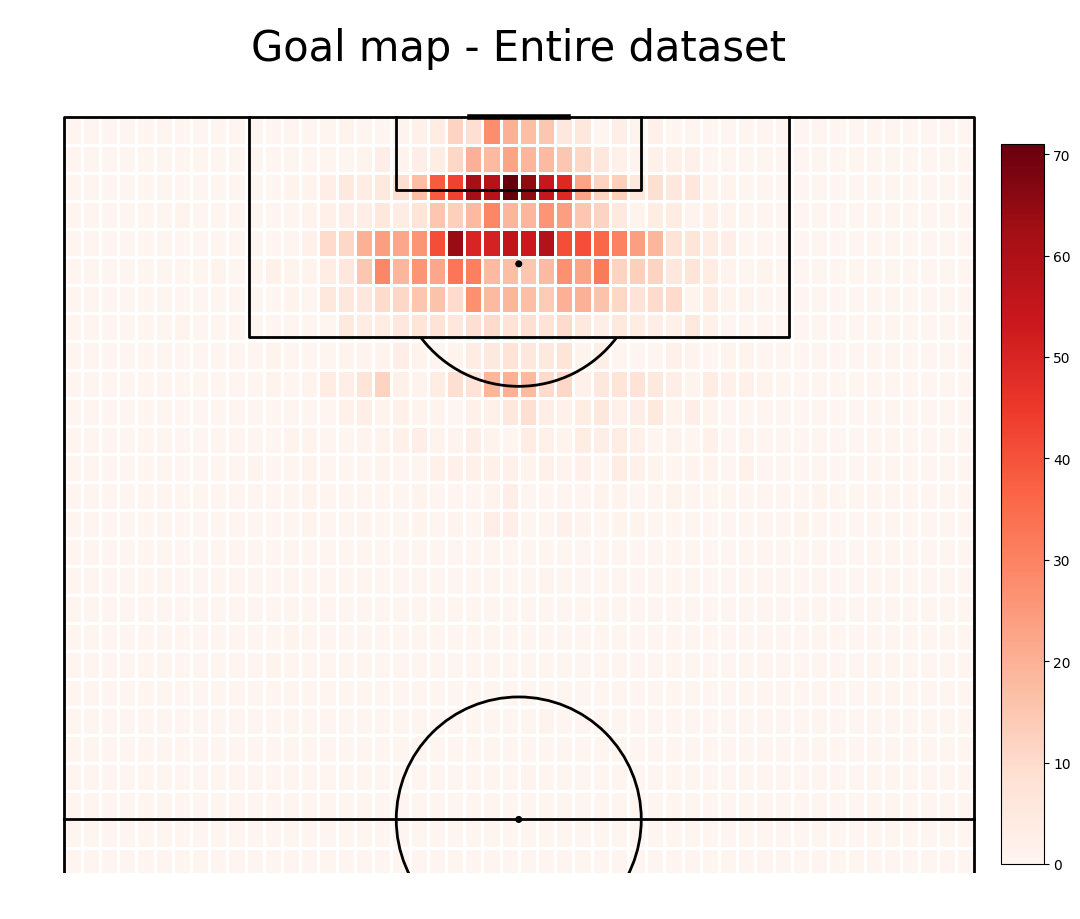

In [ ]:
#take only goals
goals = df_copy.loc[df_copy["goal"] == True]
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#calculate number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105 - goals["X"], goals["Y"], bins=50)
#plot heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal map - Entire dataset' , fontsize = 30)
plt.show()

In [ ]:
goals.shape

(2968, 143)

In [ ]:
goals["goal"].value_counts()

,count
goal,
True,2968


<ipython-input-21-4d413e851de3>:7: RuntimeWarning: invalid value encountered in divide
  bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]


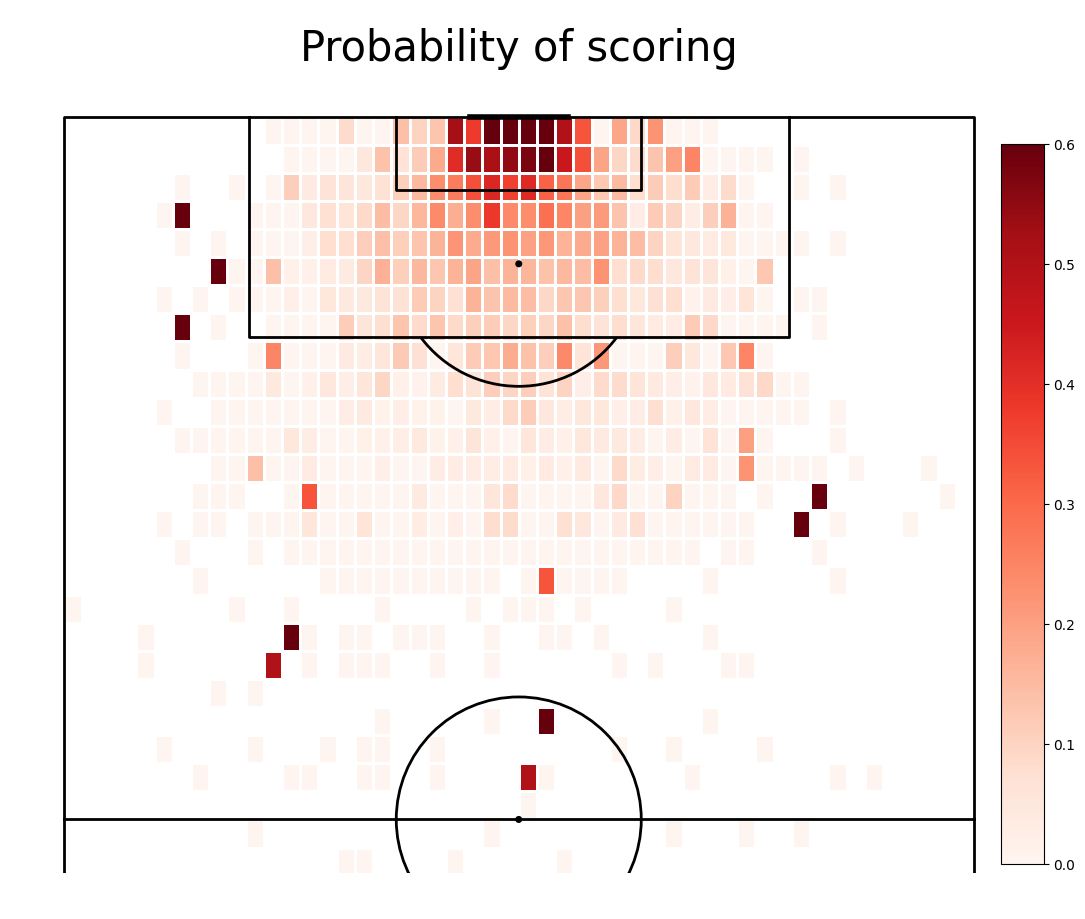

In [ ]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic = pitch.bin_statistic(105 - df_copy["X"], df_copy["Y"], bins=50)
#normalize number of goals by number of shots
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]
#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of scoring' , fontsize = 30)
plt.show()

### Logistic Curve

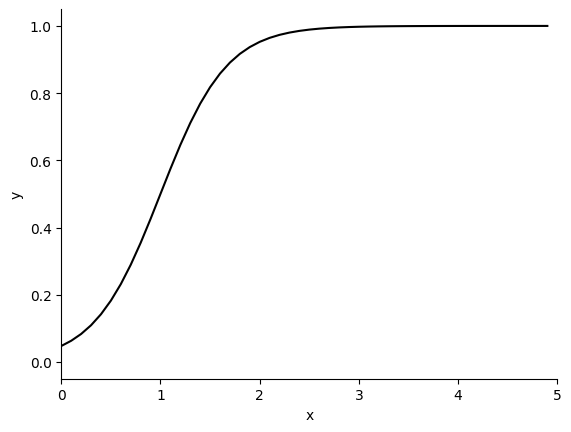

In [ ]:
b = [3, -3]
x = np.arange(5, step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x))
fig,ax = plt.subplots()
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x")
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Investigating the relationship between goals and angle

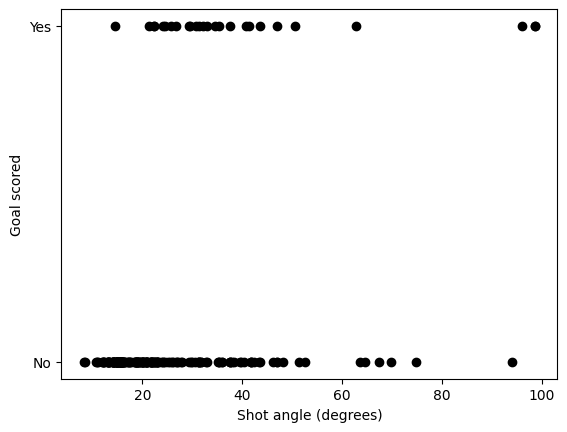

In [ ]:
#first 200 shots
shots_200=df_copy.iloc[:200]
#plot first 200 shots goal angle
fig, ax = plt.subplots()
ax.plot(shots_200['Angle']*180/np.pi, shots_200['goal'], linestyle='none', marker= '.', markersize= 12, color='black')
#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

### Investigating the relationship between probability of scoring goals and angle

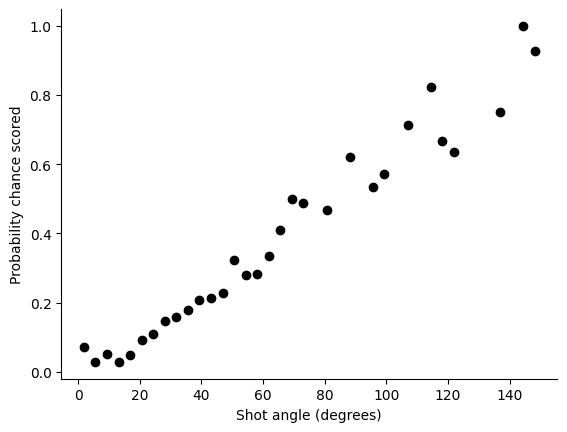

In [ ]:
#number of shots from angle
shotcount_dist = np.histogram(df_copy['Angle']*180/np.pi, bins=40, range=[0, 150])
#number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')
#probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2
#make plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Fitting with random coefficients

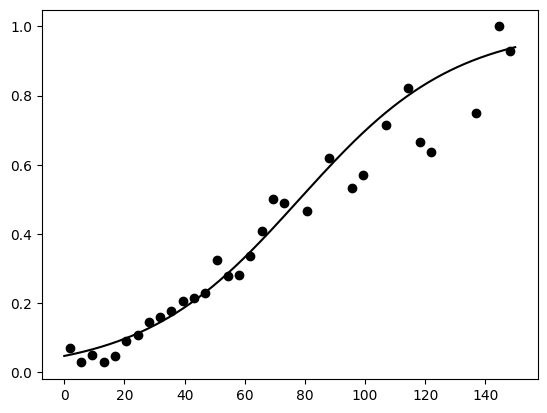

In [ ]:
fig, ax = plt.subplots()
b = [3, -2.2]
x = np.arange(150,step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180))
#plot line
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

### Calculating log likelihood

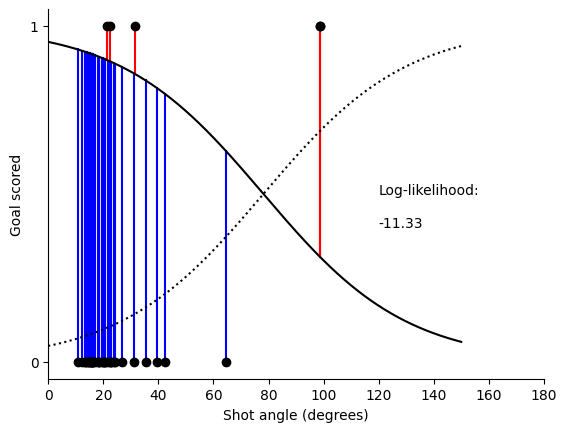

In [ ]:
#calculate xG
xG = 1/(1+np.exp(b[0]+b[1]*df_copy['Angle']))
df_copy = df_copy.assign(xG = xG)
shots_40 = df_copy.iloc[:40]
fig, ax = plt.subplots()
#plot data
ax.plot(shots_40['Angle']*180/np.pi, shots_40['goal'], linestyle='none', marker= '.', markersize= 12, color='black', zorder = 3)
#plot curves
ax.plot(x, y, linestyle=':', color='black', zorder = 2)
ax.plot(x, 1-y, linestyle='solid', color='black', zorder = 2)
#calculate loglikelihood
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang = shot['Angle'] * 180/np.pi
    if shot['goal'] == True:
        loglikelihood = loglikelihood + np.log(shot['xG'])
        ax.plot([ang,ang],[shot['goal'],1-shot['xG']], color='red', zorder = 1)
    else:
        loglikelihood = loglikelihood + np.log(1 - shot['xG'])
        ax.plot([ang,ang], [shot['goal'], 1-shot['xG']], color='blue', zorder = 1)
#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,180))
plt.text(120,0.5,'Log-likelihood:')
plt.text(120,0.4,str(loglikelihood)[:6])
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Fitting logistic regression and finding best parameters

                       Generalized Linear Model Regression Results                       
Dep. Variable:     ['goal[False]', 'goal[True]']   No. Observations:                26460
Model:                                       GLM   Df Residuals:                    26458
Model Family:                           Binomial   Df Model:                            1
Link Function:                             Logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -8340.7
Date:                           Sun, 18 May 2025   Deviance:                       16681.
Time:                                   10:38:46   Pearson chi2:                 2.57e+04
No. Iterations:                                5   Pseudo R-squ. (CS):            0.06911
Covariance Type:                       nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

<ipython-input-33-454dd53fcc75>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xGprob = 1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180))


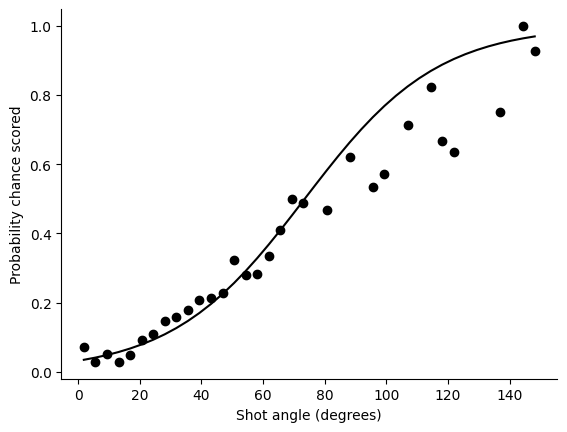

In [ ]:
#create model
test_model = smf.glm(formula="goal ~ Angle" , data=df_copy,
                           family=sm.families.Binomial()).fit()
print(test_model.summary())
#get params
b=test_model.params
#calculate xG
xGprob = 1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180))
fig, ax = plt.subplots()
#plot data
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot line
ax.plot(midangle, xGprob, linestyle='solid', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Investigating the relationship between probability of scoring goals and distance to goal

                       Generalized Linear Model Regression Results                       
Dep. Variable:     ['goal[False]', 'goal[True]']   No. Observations:                26460
Model:                                       GLM   Df Residuals:                    26458
Model Family:                           Binomial   Df Model:                            1
Link Function:                             Logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -8303.5
Date:                           Sun, 18 May 2025   Deviance:                       16607.
Time:                                   10:40:45   Pearson chi2:                 3.07e+04
No. Iterations:                                6   Pseudo R-squ. (CS):            0.07172
Covariance Type:                       nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

<ipython-input-34-b34540047e61>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xGprob=1/(1+np.exp(b[0]+b[1]*middistance))


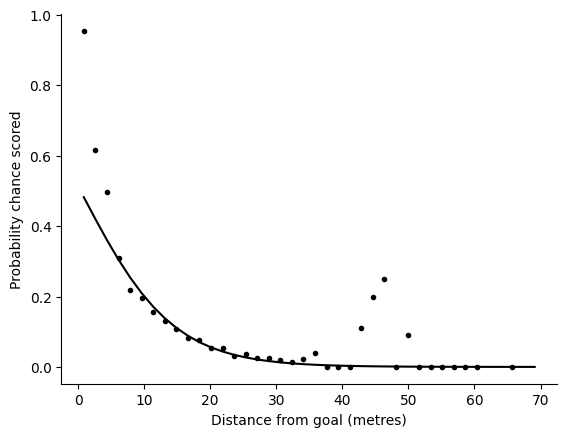

In [ ]:
#number of shots
shotcount_dist = np.histogram(df_copy['Distance'],bins=40,range=[0, 70])
#number of goals
goalcount_dist = np.histogram(goals['Distance'],bins=40,range=[0, 70])
#empirical probability of scoring
prob_goal = np.divide(goalcount_dist[0],shotcount_dist[0])
distance = shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
#making a plot
fig, ax = plt.subplots()
#plotting data
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#making legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#make single variable model of distance
test_model = smf.glm(formula="goal ~ Distance" , data=df_copy,
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance))
#plot line
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

### Adding squared distance to the model

                       Generalized Linear Model Regression Results                       
Dep. Variable:     ['goal[False]', 'goal[True]']   No. Observations:                26460
Model:                                       GLM   Df Residuals:                    26457
Model Family:                           Binomial   Df Model:                            2
Link Function:                             Logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -8274.6
Date:                           Sun, 18 May 2025   Deviance:                       16549.
Time:                                   10:41:57   Pearson chi2:                 2.71e+04
No. Iterations:                                7   Pseudo R-squ. (CS):            0.07375
Covariance Type:                       nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

<ipython-input-35-a53fab013759>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2)))


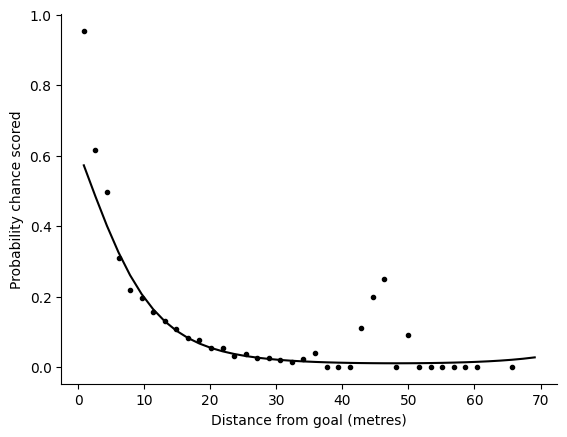

In [ ]:
#calculating distance squared
df_copy["D2"] = df_copy['Distance']**2
#adding it to the model
test_model = smf.glm(formula="goal ~ Distance + D2" , data=df_copy,
                           family=sm.families.Binomial()).fit()
#print model summary
print(test_model.summary())
#get parameters
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2)))
fig, ax = plt.subplots()
#plot line
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

### Adding squared distance to the model

                       Generalized Linear Model Regression Results                       
Dep. Variable:     ['goal[False]', 'goal[True]']   No. Observations:                26460
Model:                                       GLM   Df Residuals:                    26452
Model Family:                           Binomial   Df Model:                            7
Link Function:                             Logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -8195.2
Date:                           Sun, 18 May 2025   Deviance:                       16390.
Time:                                   10:44:40   Pearson chi2:                 2.71e+04
No. Iterations:                                8   Pseudo R-squ. (CS):            0.07929
Covariance Type:                       nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

<ipython-input-36-4a3f5b07ed21>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsum=b[0]
<ipython-input-36-4a3f5b07ed21>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsum=bsum+b[i+1]*sh[v]


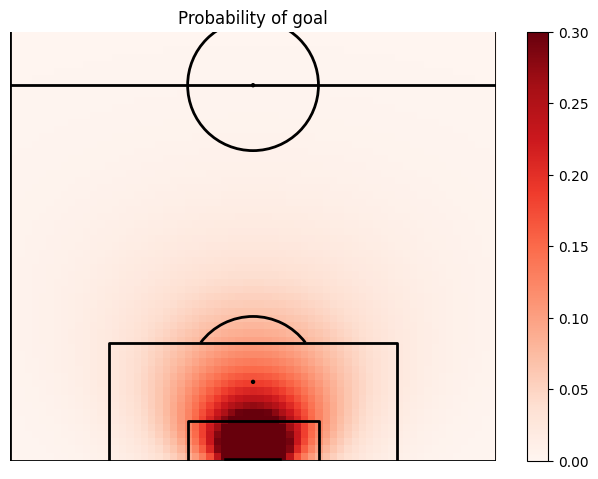

In [ ]:
#creating extra variables
df_copy["X2"] = df_copy['X']**2
df_copy["C2"] = df_copy['C']**2
df_copy["AX"]  = df_copy['Angle']*df_copy['X']

# list the model variables you want here
model_variables = ['Angle','Distance','X','C', "X2", "C2", "AX"]
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#fit the model
test_model = smf.glm(formula="goal ~ " + model, data=df_copy,
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())
b=test_model.params

#return xG value for more general model
def calculate_xG(sh):
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum))
   return xG

#add an xG to my dataframe
xG=df_copy.apply(calculate_xG, axis=1)
df_copy = df_copy.assign(xG=xG)

#Create a 2D map of xG
pgoal_2d=np.zeros((68,68))
for x in range(68):
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['D2'] = x**2 + abs(y-68/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-68/2)
        sh['C2'] = (y-68/2)**2

        pgoal_2d[x,y] =  calculate_xG(sh)

#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.draw()
#plot probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder = 1)
fig.colorbar(pos, ax=ax)
#make legend
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Testing model fit

Mcfaddens Rsquared 0.11767553507734274


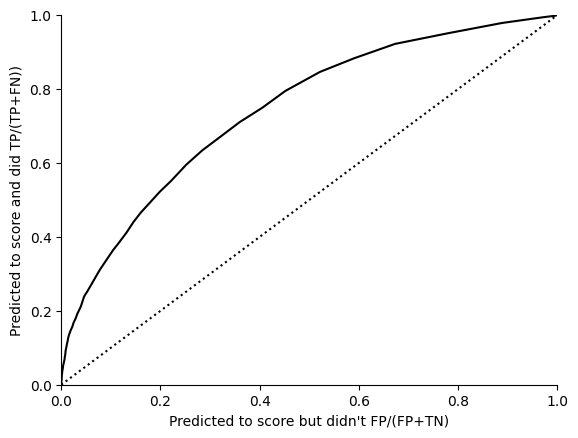

In [ ]:
# Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=df_copy,
                     family=sm.families.Binomial()).fit()
print("Mcfaddens Rsquared", 1 - test_model.llf / null_model.llf)

# ROC curve
numobs = 100
TP = np.zeros(numobs)
FP = np.zeros(numobs)
TN = np.zeros(numobs)
FN = np.zeros(numobs)

for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for j, shot in df_copy.iterrows():
        if (shot['goal'] == True):
            if (shot['xG'] > threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['goal'] == False):
            if (shot['xG'] > threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

fig, ax = plt.subplots()
ax.plot(FP / (FP + TN), TP / (TP + FN), color='black')
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
df_copy.to_csv("/content/drive/MyDrive/footly_data/xG_done", index=False)

In [ ]:
# List of columns to keep
columns_to_keep = [
    'id',
    'start_x',
    'start_y',
    'end_x',
    'end_y',
    'player_id',
    'team_id',
    'player_position',
    'season',
    'possession_id',
    'minute',
    'type',
    'shot_id',
    'goal',
    'X',
    'Y',
    'C',
    'Distance',
    'Angle',
    'possession_set_piece_attack',
    'xG',
    'D2',
    'X2',
    'C2',
    'AX',
    'clear_header',
    'shot_on_post',
    'under_pressure',
    'shot_against_gkid',
    'possession_counterattack',
    'possession_free_kick_cross',
    'period',
    'shot_after_throw_in',
    'shot_after_free_kick',
    'goalkeeper_exit',
    'shot_on_target',
    'shot_body_part',
    'shot_block',
    'penalty',
    'free_kick',
    'match_state',
    'free_kick_shot',
    'possession_duration',
    'shot_after_corner'
]

# Select only the desired columns
df_done = df_copy[columns_to_keep]

# Display the first few rows to verify
df_done.head()

In [ ]:
df_copy.head(1)

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,X,Y,C,Distance,Angle,xG,D2,X2,C2,AX
0,AMF,False,94,False,False,False,False,False,shot,False,...,6.3,39.44,-5.44,8.323677,0.689889,0.220306,69.2836,39.69,29.5936,4.346304


In [ ]:
df_done.head(1)

,id,start_x,start_y,end_x,end_y,player_id,team_id,player_position,season,possession_id,...,goalkeeper_exit,shot_on_target,shot_body_part,shot_block,penalty,free_kick,match_state,free_kick_shot,possession_duration,shot_after_corner
0,1296149438,94,42,-1,-1,302292,1609,AMF,2021,1296149405,...,False,False,left_foot,False,False,False,0,False,59.297256,False


In [ ]:
df_done.to_csv("/content/drive/MyDrive/footly_data/xG_done_filtered", index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/footly_data/xG_done_filtered")
df.head()

In [ ]:
!pip install fastparquet

In [ ]:
import pyarrow
import fastparquet

In [ ]:
df.to_parquet("/content/drive/MyDrive/footly_data/xG_done_filtered.parquet", index=False)

# Testing

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/footly_data/xG_done_filtered.parquet")

In [ ]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)
df.head(3)

,id,start_x,start_y,end_x,end_y,player_id,team_id,player_position,season,possession_id,minute,type,shot_id,goal,X,Y,C,Distance,Angle,possession_set_piece_attack,xG,D2,X2,C2,AX,clear_header,shot_on_post,under_pressure,shot_against_gkid,possession_counterattack,possession_free_kick_cross,period,shot_after_throw_in,shot_after_free_kick,goalkeeper_exit,shot_on_target,shot_body_part,shot_block,penalty,free_kick,match_state,free_kick_shot,possession_duration,shot_after_corner
0,1296149438,94,42,-1,-1,302292,1609,AMF,2021,1296149405,4,shot,0,False,6.30,39.44,-5.44,8.323677,0.689889,False,0.220306,69.2836,39.6900,29.5936,4.346304,False,False,False,-1,False,False,1,False,False,False,False,left_foot,False,False,False,0,False,59.297256,False
1,1296149466,84,38,-1,-1,520291,1609,RAMF,2021,1296149442,5,shot,0,False,16.80,42.16,-8.16,18.676873,0.351405,True,0.071469,348.8256,282.2400,66.5856,5.903610,False,False,False,-1,False,False,1,False,False,False,False,left_foot,False,False,False,0,False,31.034252,False
2,1296149542,79,67,-1,-1,120339,1609,RDMF,2021,1296149527,9,shot,0,False,22.05,22.44,11.56,24.896508,0.260123,False,0.038165,619.8361,486.2025,133.6336,5.735708,False,False,False,-1,False,False,1,False,False,False,False,right_foot,False,False,False,0,False,30.175322,False


In [ ]:
df.shape

(26460, 44)

In [ ]:
team_df = df[df["team_id"] == 1609]
team_df.shape

(1638, 44)

In [ ]:
df_limited = team_df.head(600)
df_limited.shape

(600, 44)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import VerticalPitch
import pandas as pd

# Function to create heatmap for a specific team
def create_team_heatmap(df, team_id=None, title_prefix=""):
    # Filter data by team_id if provided
    if team_id is not None:
        team_df = df[df['team_id'] == team_id].copy()
        title = f"{title_prefix} Team {team_id} xG Heatmap"
    else:
        team_df = df.copy()
        title = f"{title_prefix} All Teams xG Heatmap"

    # Check if we have shots for this team
    if len(team_df) == 0:
        print(f"No shots data available for team_id {team_id}")
        return None

    # We'll use the same model parameters as before, but now with filtered data

    # Create a 2D map of xG using our existing model
    pgoal_2d = np.zeros((68, 68))

    # Create a heatmap based on actual shots by binning
    x_bins = np.linspace(0, 68, 68)
    y_bins = np.linspace(0, 68, 68)

    # Initialize the grid for heatmap
    shot_grid = np.zeros((len(x_bins)-1, len(y_bins)-1))
    xg_grid = np.zeros((len(x_bins)-1, len(y_bins)-1))

    # Assign shots to grid cells
    for _, shot in team_df.iterrows():
        x_idx = int(shot['X'])
        y_idx = int(shot['Y'])

        # Make sure the indices are within bounds
        if 0 <= x_idx < 68 and 0 <= y_idx < 68:
            shot_grid[x_idx, y_idx] += 1
            xg_grid[x_idx, y_idx] += shot['xG']

    # Calculate average xG per location
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_xg_grid = np.divide(xg_grid, shot_grid)
        avg_xg_grid = np.nan_to_num(avg_xg_grid)  # Replace NaN with 0

    # Plot pitch
    pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom',
                          pitch_length=105, pitch_width=68, line_zorder=2)
    fig, ax = pitch.draw()

    # Plot probability
    pos = ax.imshow(avg_xg_grid, extent=[-1, 68, 68, -1], aspect='auto',
                    cmap=plt.cm.Reds, vmin=0, vmax=0.3, zorder=1)
    fig.colorbar(pos, ax=ax)

    # Calculate shot frequency and total xG
    total_shots = len(team_df)
    total_xg = team_df['xG'].sum()
    actual_goals = team_df['goal'].sum()

    # Make legend
    ax.set_title(f"{title}\n{total_shots} shots, {actual_goals} goals, {total_xg:.2f} total xG")
    plt.xlim((0, 68))
    plt.ylim((0, 60))
    plt.gca().set_aspect('equal', adjustable='box')

    return fig, ax

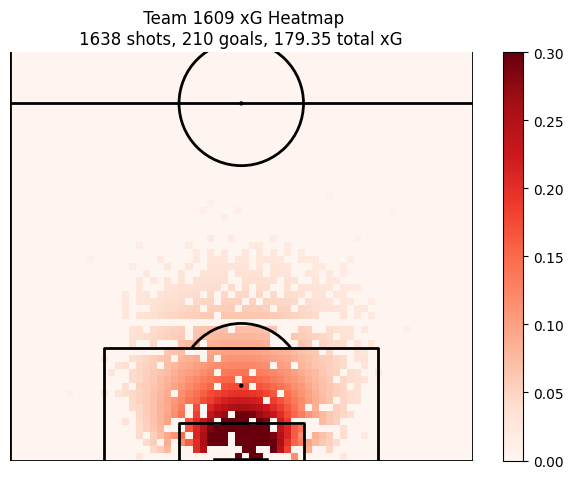

In [ ]:
team_id = 1609  # Example: first team
fig_team, ax_team = create_team_heatmap(df, team_id=team_id, title_prefix="")
plt.show()

### Variable bins

In [ ]:
# Function to create heatmap for a specific team
def create_team_heatmap_2(df, team_id=None, title_prefix="", bins=17):
    """
    Create an xG heatmap for shots from a specific team

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing shot data with xG values
    team_id : int or None
        Team ID to filter by, or None for all teams
    title_prefix : str
        Prefix to add to the plot title
    bin_count : int
        Number of bins in each dimension (controls smoothness)
    """
    # Filter data by team_id if provided
    if team_id is not None:
        team_df = df[df['team_id'] == team_id].copy()
        title = f"{title_prefix} Team {team_id} xG Heatmap"
    else:
        team_df = df.copy()
        title = f"{title_prefix} All Teams xG Heatmap"

    # Check if we have shots for this team
    if len(team_df) == 0:
        print(f"No shots data available for team_id {team_id}")
        return None

    # We'll use the same model parameters as before, but now with filtered data

    # Create a 2D map of xG using our existing model
    pgoal_2d = np.zeros((68, 68))

    # Create a heatmap based on actual shots by binning
    # Use fewer bins for a coarser/smoother heatmap
    # For example, 17 bins gives us roughly 4x4 meter grid cells
    bin_count = bins  # Adjust this number to change the bin size
    x_bins = np.linspace(0, 68, bin_count)
    y_bins = np.linspace(0, 68, bin_count)

    # Initialize the grid for heatmap
    shot_grid = np.zeros((len(x_bins)-1, len(y_bins)-1))
    xg_grid = np.zeros((len(x_bins)-1, len(y_bins)-1))

    # Assign shots to grid cells
    for _, shot in team_df.iterrows():
        # Find the bin indices for this shot
        x_idx = np.digitize(shot['X'], x_bins) - 1
        y_idx = np.digitize(shot['Y'], y_bins) - 1

        # Make sure the indices are within bounds
        if 0 <= x_idx < len(x_bins)-1 and 0 <= y_idx < len(y_bins)-1:
            shot_grid[x_idx, y_idx] += 1
            xg_grid[x_idx, y_idx] += shot['xG']

    # Calculate average xG per location
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_xg_grid = np.divide(xg_grid, shot_grid)
        avg_xg_grid = np.nan_to_num(avg_xg_grid)  # Replace NaN with 0

    # Plot pitch
    pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom',
                          pitch_length=105, pitch_width=68, line_zorder=2)
    fig, ax = pitch.draw()

    # Plot probability with interpolation for smoother appearance
    pos = ax.imshow(avg_xg_grid, extent=[0, 68, 68, 0], aspect='auto',
                    cmap=plt.cm.Reds, vmin=0, vmax=0.3, zorder=1,
                    interpolation='gaussian')
    fig.colorbar(pos, ax=ax)

    # Calculate shot frequency and total xG
    total_shots = len(team_df)
    total_xg = team_df['xG'].sum()
    actual_goals = team_df['goal'].sum()

    # Make legend
    ax.set_title(f"{title}\n{total_shots} shots, {actual_goals} goals, {total_xg:.2f} total xG")
    plt.xlim((0, 68))
    plt.ylim((0, 60))
    plt.gca().set_aspect('equal', adjustable='box')

    return fig, ax

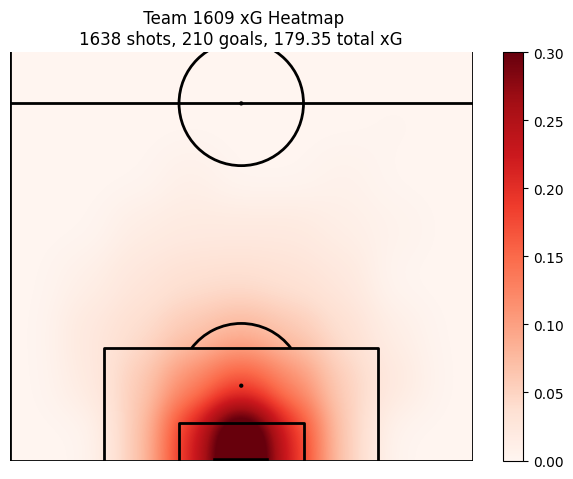

In [ ]:
team_id = 1609  # Example: first team
fig_team, ax_team = create_team_heatmap_2(df, team_id=team_id, title_prefix="", bins=10)
plt.show()

### ostalo

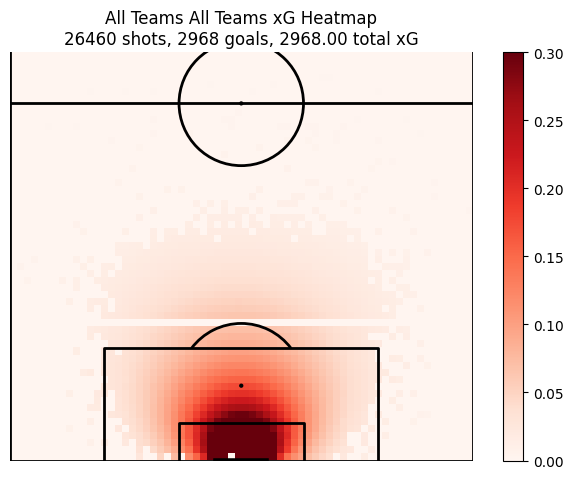

Available team IDs: [1609 1623 1630 1669 1633 1651 1613 1646 1610 1644 1611 1628 1631 1619
 1629 1612 1625 1614 1624 1626 1642 1616 1659 1660 1636]


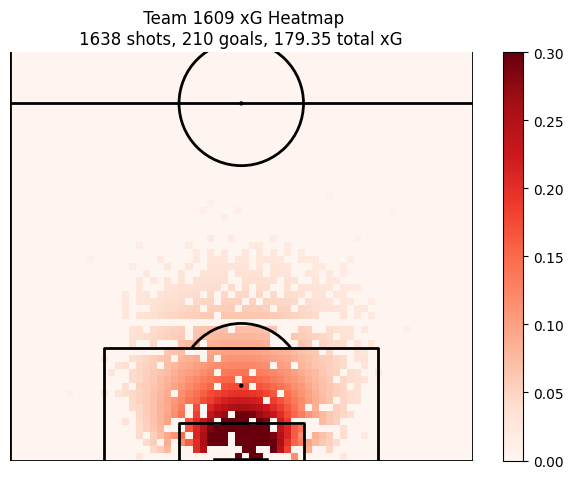

In [ ]:
# Example usage:
# Assuming df is your dataframe with calculated xG values

# Create heatmap for all teams
fig_all, ax_all = create_team_heatmap(df, title_prefix="All Teams")
plt.show()

# Get all unique team IDs
team_ids = df['team_id'].unique()
print(f"Available team IDs: {team_ids}")

# Create heatmap for a specific team (example with first team in the list)
if len(team_ids) > 0:
    team_id = team_ids[0]  # Example: first team
    fig_team, ax_team = create_team_heatmap(df, team_id=team_id, title_prefix="")
    plt.show()

In [ ]:


# Example usage:
# Assuming df_copy is your dataframe with calculated xG values

# Create heatmap for all teams
fig_all, ax_all = create_team_heatmap(df_copy, title_prefix="All Teams")
plt.show()

# Get all unique team IDs
team_ids = df_copy['team_id'].unique()
print(f"Available team IDs: {team_ids}")

# Create heatmap for a specific team (example with first team in the list)
if len(team_ids) > 0:
    team_id = team_ids[0]  # Example: first team
    fig_team, ax_team = create_team_heatmap(df_copy, team_id=team_id, title_prefix="")
    plt.show()

# Compare multiple teams
def compare_team_heatmaps(df, team_ids, figsize=(15, 10)):
    """Create heatmaps for multiple teams for comparison"""
    n_teams = len(team_ids)
    cols = min(3, n_teams)
    rows = (n_teams + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if n_teams > 1 else [axes]

    for i, team_id in enumerate(team_ids):
        if i < len(axes):
            team_df = df[df['team_id'] == team_id].copy()

            # Skip if no data
            if len(team_df) == 0:
                axes[i].text(0.5, 0.5, f"No data for team {team_id}",
                             ha='center', va='center')
                continue

            # Create a pitch on the subplot
            pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom',
                                 pitch_length=105, pitch_width=68, line_zorder=2, ax=axes[i])

            # Calculate average xG per location
            x_bins = np.linspace(0, 68, 68)
            y_bins = np.linspace(0, 68, 68)

            shot_grid = np.zeros((len(x_bins)-1, len(y_bins)-1))
            xg_grid = np.zeros((len(x_bins)-1, len(y_bins)-1))

            for _, shot in team_df.iterrows():
                x_idx = int(shot['X'])
                y_idx = int(shot['Y'])

                if 0 <= x_idx < 68 and 0 <= y_idx < 68:
                    shot_grid[x_idx, y_idx] += 1
                    xg_grid[x_idx, y_idx] += shot['xG']

            with np.errstate(divide='ignore', invalid='ignore'):
                avg_xg_grid = np.divide(xg_grid, shot_grid)
                avg_xg_grid = np.nan_to_num(avg_xg_grid)

            # Plot heatmap
            pos = axes[i].imshow(avg_xg_grid, extent=[-1, 68, 68, -1], aspect='auto',
                               cmap=plt.cm.Reds, vmin=0, vmax=0.3, zorder=1)

            # Stats
            total_shots = len(team_df)
            total_xg = team_df['xG'].sum()
            actual_goals = team_df['goal'].sum()

            axes[i].set_title(f"Team {team_id}\n{total_shots} shots, {actual_goals} goals, {total_xg:.2f} xG")

    # Add a colorbar to the last subplot
    if n_teams > 0:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(pos, cax=cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Example: Compare the first 4 teams
if len(team_ids) >= 4:
    compare_team_heatmaps(df_copy, team_ids[:4])

# Alternative: Create heatmaps for top 4 teams by number of shots
team_shot_counts = df_copy.groupby('team_id').size().sort_values(ascending=False)
top_teams = team_shot_counts.head(4).index.tolist()
compare_team_heatmaps(df_copy, top_teams)